In [61]:
import numpy as np
import pandas as pd

In [73]:
# Kh·ªüi t·∫°o tham s·ªë cho m√¥ h√¨nh
# Chi ph√≠ kho
O = 50.0 # Chi ph√≠ ƒë·∫∑t h√†ng
h_year = 10.0 # Chi ph√≠ l∆∞u tr·ªØ (10 ƒë√¥ cho 1 s·∫£n ph·∫©m / nƒÉm)
b = 20.0 # Chi ph√≠ thi·∫øu h√†ng (20 ƒë√¥ cho 1 m·ªói s·∫£n ph·∫©m t·ªìn ƒë·ªçng)
LT = 1 # Lead Time = 1 ng√†y (ƒë∆°n h√†ng ƒë∆∞·ª£c ƒë·∫∑t h√¥m nay s·∫Ω ƒë·∫øn v√†o ng√†y k·∫ø ti·∫øp)
days_per_year = 365 # S·ªë ng√†y trong m·ªôt nƒÉm
h = h_year/days_per_year # Chi ph√≠ l∆∞u tr·ªØ quy ƒë·ªïi theo ng√†y
q = 6 # S·ªë l∆∞·ª£ng ƒë·∫∑t h√†ng m·ªói l·∫ßn
r = 3 # M·ª©c t·ªìn kho ƒë·∫∑t h√†ng l·∫°i (reorder point)

# Nhu c·∫ßu
mu = 3.0        # Nhu c·∫ßu trung b√¨nh m·ªói ng√†y
sigma = 1.0     # ƒê·ªô l·ªách chu·∫©n c·ªßa nhu c·∫ßu

# Tham s·ªë c·ªßa Q-learning
alpha = 0.2 # T·ªëc ƒë·ªô h·ªçc
gamma = 0.9 # H·ªá s·ªë chi·∫øt kh·∫•u (0<gamma<1)
epsilon = 0.1 # H·ªá s·ªë kh√°m ph√° l√† 10%
num_episodes = 1000      # t·ªïng s·ªë chu k·ª≥ h·ªçc
episode_length = 1000    # m·ªói chu k·ª≥ = 1000 ng√†y m√¥ ph·ªèng


In [ ]:
# M√¥i tr∆∞·ªùng h·ªçc (state, action)

# Tr·∫°ng th√°i: v·ªã tr√≠ t·ªìn kho (inventory position)
# D·∫£i gi√° tr·ªã t·ªìn kho [-20, 20] (√¢m = thi·∫øu h√†ng)
min_IP, max_IP = -20, 20
states = np.arange(min_IP, max_IP + 1)

# H√†nh ƒë·ªông: 0 = kh√¥ng ƒë·∫∑t h√†ng, 1 = ƒë·∫∑t h√†ng (s·ªë l∆∞·ª£ng q)
actions = [0, 1]

# Kh·ªüi t·∫°o b·∫£ng Q-table (s·ªë tr·∫°ng th√°i x s·ªë h√†nh ƒë·ªông)
Q = np.zeros((len(states), len(actions)))

def ip_to_index(ip):
    """Chuy·ªÉn gi√° tr·ªã t·ªìn kho sang ch·ªâ s·ªë m·∫£ng Q-table """
    return int(np.clip(round(ip), min_IP, max_IP)) - min_IP


def sample_demand():
    """T·∫°o nhu c·∫ßu ng·∫´u nhi√™n theo ph√¢n ph·ªëi chu·∫©n N(Œº, œÉ), kh√¥ng √¢m."""
    d = np.random.normal(mu, sigma)
    return max(0, int(round(d)))


def step(ip, orders_in_transit, action):
    # Nh·∫≠p h√†ng ƒë·∫øn
    arrivals = 0
    if orders_in_transit > 0:
        arrivals = orders_in_transit
        orders_in_transit = 0

    # C·∫≠p nh·∫≠t t·ªìn kho sau khi nh·∫≠n h√†ng
    ip_after_arrival = ip + arrivals

    # Tr·ª´ ƒëi nhu c·∫ßu
    d = sample_demand()
    ip_after_demand = ip_after_arrival - d

    # N·∫øu h√†nh ƒë·ªông = ƒë·∫∑t h√†ng ‚Üí ƒë∆°n h√†ng s·∫Ω ƒë·∫øn v√†o ng√†y sau
    order_placed = False
    # if action == 1:
    #     order_placed = True
    #     orders_in_transit = q
    
    # Ch√≠nh s√°ch ƒë·∫∑t h√†ng: ch·ªâ ƒë·∫∑t h√†ng khi kh√¥ng c√≥ ƒë∆°n h√†ng n√†o ƒëang tr√™n ƒë∆∞·ªùng v√† t·ªìn kho sau nhu c·∫ßu < r
    if orders_in_transit == 0 and (action == 1 or ip_after_demand < r):
        order_placed = True
        orders_in_transit = q  
    
    # T√≠nh chi ph√≠
    holding_cost = h * max(ip_after_demand, 0)
    backorder_cost = b * max(-ip_after_demand, 0)
    ordering_cost = O if order_placed else 0
    total_cost = holding_cost + backorder_cost + ordering_cost

    # Ph·∫ßn th∆∞·ªüng = -chi ph√≠ (RL mu·ªën t·ªëi ƒëa h√≥a reward)
    reward = -total_cost
    next_ip = ip_after_demand

    return next_ip, reward, orders_in_transit, total_cost


In [75]:
# -----------------------------
# 5Ô∏è‚É£ V√≤ng l·∫∑p hu·∫•n luy·ªán Q-learning (epsilon c·ªë ƒë·ªãnh = 0.1, in log t·ª´ng episode)
# -----------------------------
episode_costs = []
episode_holding = []
episode_backorder = []
episode_ordering = []

epsilon = 0.1  # X√°c su·∫•t kh√°m ph√° c·ªë ƒë·ªãnh

for ep in range(num_episodes):

    ip = r  # t·ªìn kho ban ƒë·∫ßu = ƒëi·ªÉm ƒë·∫∑t h√†ng l·∫°i
    orders_in_transit = 0
    total_cost_ep = 0
    holding_ep = 0
    backorder_ep = 0
    ordering_ep = 0

    for day in range(episode_length):
        s_idx = ip_to_index(ip)

        # Epsilon-greedy: kh√°m ph√° ho·∫∑c khai th√°c
        if np.random.rand() < epsilon:
            a = np.random.choice(actions)
        else:
            qvals = Q[s_idx, :]
            a = np.random.choice(np.flatnonzero(qvals == qvals.max()))

        # --- M√¥ ph·ªèng m·ªôt b∆∞·ªõc ---
        arrivals = 0
        if orders_in_transit > 0:
            arrivals = orders_in_transit
            orders_in_transit = 0

        ip_after_arrival = ip + arrivals
        d = sample_demand()
        ip_after_demand = ip_after_arrival - d

        order_placed = False
        if a == 1:
            order_placed = True
            orders_in_transit = q

        holding_cost = h * max(ip_after_demand, 0)
        backorder_cost = b * max(-ip_after_demand, 0)
        ordering_cost = O if order_placed else 0
        total_cost = holding_cost + backorder_cost + ordering_cost

        reward = -total_cost
        next_ip = ip_after_demand

        # --- C·∫≠p nh·∫≠t Q-learning ---
        s_next = ip_to_index(next_ip)
        Q[s_idx, a] += alpha * (reward + gamma * np.max(Q[s_next, :]) - Q[s_idx, a])

        # --- C·ªông d·ªìn chi ph√≠ ---
        total_cost_ep += total_cost
        holding_ep += holding_cost
        backorder_ep += backorder_cost
        ordering_ep += ordering_cost

        ip = next_ip

    # L∆∞u k·∫øt qu·∫£ c·ªßa episode n√†y
    episode_costs.append(total_cost_ep)
    episode_holding.append(holding_ep)
    episode_backorder.append(backorder_ep)
    episode_ordering.append(ordering_ep)

    # ‚úÖ In ra t·ª´ng episode
    print(f"Episode {ep + 1}/{num_episodes} | T·ªïng chi ph√≠: {total_cost_ep:.2f} "
          f"(Holding={holding_ep:.2f}, Backorder={backorder_ep:.2f}, Ordering={ordering_ep:.2f})")

print("\n‚úÖ Hu·∫•n luy·ªán ho√†n t·∫•t.")


Episode 1/1000 | T·ªïng chi ph√≠: 3081932.08 (Holding=2.08, Backorder=3059580.00, Ordering=22350.00)
Episode 2/1000 | T·ªïng chi ph√≠: 8287440.68 (Holding=0.68, Backorder=8266940.00, Ordering=20500.00)
Episode 3/1000 | T·ªïng chi ph√≠: 9621520.00 (Holding=0.00, Backorder=9601720.00, Ordering=19800.00)
Episode 4/1000 | T·ªïng chi ph√≠: 253358.82 (Holding=8.82, Backorder=228600.00, Ordering=24750.00)
Episode 5/1000 | T·ªïng chi ph√≠: 214297.95 (Holding=17.95, Backorder=189380.00, Ordering=24900.00)
Episode 6/1000 | T·ªïng chi ph√≠: 229529.10 (Holding=9.10, Backorder=204620.00, Ordering=24900.00)
Episode 7/1000 | T·ªïng chi ph√≠: 244160.79 (Holding=20.79, Backorder=218940.00, Ordering=25200.00)
Episode 8/1000 | T·ªïng chi ph√≠: 131427.45 (Holding=17.45, Backorder=106360.00, Ordering=25050.00)
Episode 9/1000 | T·ªïng chi ph√≠: 193385.21 (Holding=15.21, Backorder=168720.00, Ordering=24650.00)
Episode 10/1000 | T·ªïng chi ph√≠: 120775.86 (Holding=15.86, Backorder=95860.00, Ordering=24900.00)

In [76]:
# Tr√≠ch xu·∫•t ch√≠nh s√°ch t·ªëi ∆∞u t·ª´ Q-table
policy = np.argmax(Q, axis=1)  # ch·ªçn h√†nh ƒë·ªông t·ªët nh·∫•t ·ªü m·ªói tr·∫°ng th√°i

In [77]:
# M√¥ ph·ªèng ƒë√°nh gi√° ch√≠nh s√°ch
def learned_policy(ip):
    """Ch√≠nh s√°ch do m√¥ h√¨nh h·ªçc ƒë∆∞·ª£c."""
    return int(policy[ip_to_index(ip)])


def rq_policy(ip):
    """Ch√≠nh s√°ch (r,q) truy·ªÅn th·ªëng."""
    return 1 if ip <= r else 0


def evaluate(policy_func, days=365 * 5, seed=42):
    """M√¥ ph·ªèng th·ª±c t·∫ø trong nhi·ªÅu ng√†y ƒë·ªÉ t√≠nh chi ph√≠ trung b√¨nh/ng√†y."""
    np.random.seed(seed)
    total_cost = 0
    ip = r
    orders_in_transit = 0
    for day in range(days):
        a = policy_func(ip)
        next_ip, _, orders_in_transit, cost = step(ip, orders_in_transit, a)
        ip = next_ip
        total_cost += cost
    return total_cost / days

In [78]:
# ƒê√°nh gi√° ch√≠nh s√°ch h·ªçc ƒë∆∞·ª£c
learned_cost = evaluate(learned_policy)
rq_cost = evaluate(rq_policy)
reduction = (rq_cost - learned_cost) / rq_cost * 100

print(f"\nüìä K·∫øt qu·∫£ so s√°nh:")
print(f" - Ch√≠nh s√°ch h·ªçc ƒë∆∞·ª£c: {learned_cost:.2f} ‚Ç¨/ng√†y")
print(f" - Ch√≠nh s√°ch (r,q) truy·ªÅn th·ªëng: {rq_cost:.2f} ‚Ç¨/ng√†y")
print(f" - T·ª∑ l·ªá c·∫£i thi·ªán: {reduction:.2f}%")


üìä K·∫øt qu·∫£ so s√°nh:
 - Ch√≠nh s√°ch h·ªçc ƒë∆∞·ª£c: 25.72 ‚Ç¨/ng√†y
 - Ch√≠nh s√°ch (r,q) truy·ªÅn th·ªëng: 26.12 ‚Ç¨/ng√†y
 - T·ª∑ l·ªá c·∫£i thi·ªán: 1.52%


In [79]:
# Hi·ªÉn th·ªã ch√≠nh s√°ch h·ªçc ƒë∆∞·ª£c
policy_df = pd.DataFrame({
    "inventory_position": states,
    "action (0=no order,1=order)": policy
})

print("\nüîé M·ªôt ph·∫ßn c·ªßa ch√≠nh s√°ch h·ªçc ƒë∆∞·ª£c:")
print(policy_df)


üîé M·ªôt ph·∫ßn c·ªßa ch√≠nh s√°ch h·ªçc ƒë∆∞·ª£c:
    inventory_position  action (0=no order,1=order)
0                  -20                            1
1                  -19                            0
2                  -18                            0
3                  -17                            1
4                  -16                            0
5                  -15                            1
6                  -14                            0
7                  -13                            0
8                  -12                            0
9                  -11                            1
10                 -10                            0
11                  -9                            0
12                  -8                            1
13                  -7                            0
14                  -6                            0
15                  -5                            0
16                  -4                            1
17        

In [80]:
# ===============================================================
# üîü M√¥ ph·ªèng 30 ng√†y ‚Äì ƒë·∫ßy ƒë·ªß c√°c bi·∫øn ƒë·ªÉ quan s√°t (gi·ªëng b√†i b√°o)
# ===============================================================
np.random.seed(123)
days = np.arange(1, 31)  # m√¥ ph·ªèng 30 ng√†y
ip = r
orders_in_transit = 0
records = []

for day in days:
    a = learned_policy(ip)   # h√†nh ƒë·ªông theo ch√≠nh s√°ch ƒë√£ h·ªçc
    d = sample_demand()      # nhu c·∫ßu ng·∫´u nhi√™n m·ªói ng√†y
    arrivals = 0

    # N·∫øu h√¥m nay c√≥ h√†ng v·ªÅ (lead time = 1)
    if orders_in_transit > 0:
        arrivals = orders_in_transit
        orders_in_transit = 0

    inventory_before = ip
    ip_after = ip + arrivals - d

    # N·∫øu h√¥m nay ƒë·∫∑t h√†ng, h√†ng s·∫Ω ƒë·∫øn ng√†y sau
    if a == 1:
        orders_in_transit = q

    # üîπ T√≠nh chi ph√≠ h·∫±ng ng√†y
    holding_cost = h * max(ip_after, 0)
    backorder_cost = b * max(-ip_after, 0)
    ordering_cost = O if a == 1 else 0
    total_cost = holding_cost + backorder_cost + ordering_cost

    # Ghi l·∫°i d·ªØ li·ªáu t·ª´ng ng√†y
    records.append({
        "day": day,
        "demand": d,
        "inventory_before": inventory_before,
        "order_action": a,
        "arrivals_today": arrivals,
        "inventory_after": ip_after,
        "daily_cost": total_cost
    })

    ip = ip_after

# üî∏ T·∫°o DataFrame k·∫øt qu·∫£
df_sim = pd.DataFrame(records)
print("\nüìÖ D·ªØ li·ªáu m√¥ ph·ªèng 30 ng√†y ƒë·∫ßu:")
print(df_sim.to_string(index=False))


üìÖ D·ªØ li·ªáu m√¥ ph·ªèng 30 ng√†y ƒë·∫ßu:
 day  demand  inventory_before  order_action  arrivals_today  inventory_after  daily_cost
   1       2                 3             0               0                1    0.027397
   2       4                 1             0               0               -3   60.000000
   3       3                -3             0               0               -6  120.000000
   4       1                -6             0               0               -7  140.000000
   5       2                -7             0               0               -9  180.000000
   6       5                -9             0               0              -14  280.000000
   7       1               -14             0               0              -15  300.000000
   8       3               -15             1               0              -18  410.000000
   9       4               -18             0               6              -16  320.000000
  10       2               -16             0         

In [81]:
import matplotlib.pyplot as plt

In [82]:
# ===============================================================
# üìà Fig.3 ‚Äì Inventory Level (Pcs)
# ===============================================================
plt.figure(figsize=(8,4))
plt.plot(df_sim["day"], df_sim["inventory_after"], marker='o', color='tab:blue', linewidth=2)
plt.xlabel("Periods (t)")
plt.ylabel("Inventory Level [pcs]")
plt.title("Fig.3 ‚Äì Inventory level over time (30 periods)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

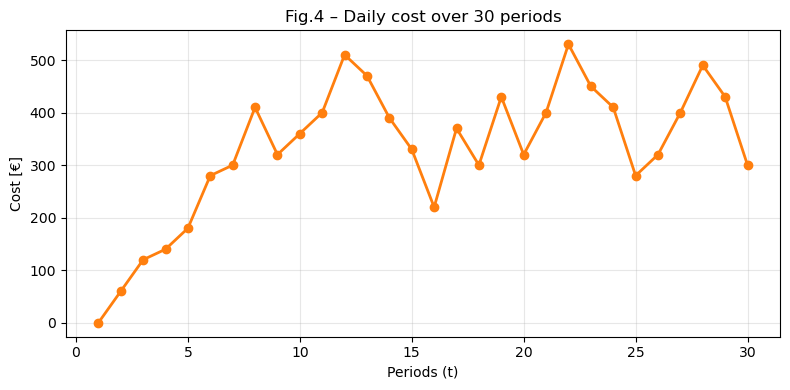

In [83]:
# ===============================================================
# üí∞ Fig.4 ‚Äì Cost (‚Ç¨)
# ===============================================================
plt.figure(figsize=(8,4))
plt.plot(df_sim["day"], df_sim["daily_cost"], marker='o', color='tab:orange', linewidth=2)
plt.xlabel("Periods (t)")
plt.ylabel("Cost [‚Ç¨]")
plt.title("Fig.4 ‚Äì Daily cost over 30 periods")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()